<a href="https://colab.research.google.com/github/mwithgod3952/jh_Natural_language_processing/blob/main/Minor_project_%EB%84%A4%EC%9D%B4%EB%B2%84_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import re
import urllib.request

# !pip install konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### 1. 데이터 확인

데이터 출처 : https://github.com/e9t/nsmc/

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f637d160550>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


#### 2 데이터 정제


In [9]:
train_data.iloc[:,1:].shape

(150000, 2)

In [10]:
 print(train_data['document'].nunique(), train_data['label'].nunique())
 print('중복데이터 수', train_data.iloc[:,1:].shape[0] - train_data['document'].nunique())

146182 2
중복데이터 수 3818


In [13]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [14]:
# 중복데이터가 제된 shape
train_data.shape

(146183, 3)

In [15]:
train_data['label'].value_counts()
# print(train_data.groupby('label').size().reset_index(name = 'count'))

0    73342
1    72841
Name: label, dtype: int64

In [16]:
# r결측값 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [17]:
# 결측값 정보 확인
# print(train_data.iloc[np.where(train_data.isnull())[0][0]])
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [18]:
# 결측값 제거
train_data = train_data.dropna(how = 'any')

In [19]:
# 한글과 공백만 남기고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [20]:
#  영어, 숫자, 특수문자로만으로 구성된 행이 있을 수 있음  > White space로 변환되었을 행의 값을 '':공백 처리하고, 
train_data['document'] = train_data['document'].str.replace('^ +', "") 
# Null 값 삽입
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [21]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [22]:
train_data = train_data.dropna(how = 'any')
train_data.document.isnull().values.any()

False

In [23]:
# 테스트 셋도 동일하게 작업 수행
    # 중복 행 제거
    # 정규표현식 수행 (특수문자 등)
    # 공백은 empty 값으로 변경 및 Null 값으로 대체
    #  Null 값 제거
test_data.drop_duplicates(subset=["document"], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')

#### 3 토큰화

##### 3-1 불용어 정의

In [24]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [27]:
# 형태소 분석 

okt = Okt()

X_train = []
for sentence in train_data['document']:
  temp_X = okt.morphs(sentence, stem=True)
  temp_X = [x for x in temp_X if not x in stopwords]
  X_train.append(temp_X)
  
X_train[:5]  

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [28]:
X_test = []

for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) 
    temp_X = [x for x in temp_X if not x in stopwords] 
    X_test.append(temp_X)

X_test[:5]    

[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '나오다', '제', '심기', '불편하다'],
 ['음악', '주가', '되다', '최고', '음악', '영화']]

#### 4 정수인코딩

      - 위, X_train 과 X_test 에 대해서, 불용처 처리만으로 단어가 완벽하게 정제되지 못함을 확인했다. 
      ㅋ d이나 리, 더와 같은 의미가 없는 단어들 또는 조합이다. 
      물론 Stopwords list 를 디테일하게 추가해가는 것도 해결 방안 중 하나이겠지만, 
      count 를 통해서, 정제처리를 해주는 것도 하나의 차선책으로 이상적일 수 있겠다. 

In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)

In [30]:

threshold = 3
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

# 단어와 빈도수 : key와 value (tokenizer.word_counts.item())
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [31]:
# 학습을 위해 빈도수가 2 이하인 단어를 제거한, 즉, 학습에 사용할 단어의 공간 만큼을 vocab size로 지정한다.
# 여기서 +1은 0번 패딩 토큰을 위해 남겨둔다
# 주의 :  정수 인코딩 과정에서 배제한 것이지 데이터는 그대로 남아있음

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [32]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [33]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [34]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

#### 5 빈 샘플(Empty sample 제거)

In [35]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

145162
145162


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 6 패딩 : 길이 맞추기 , 0 주입하기

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


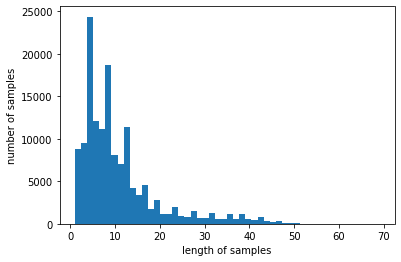

In [36]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
# 모든 샘플의 길이를 30으로 맞추기로 한다. 
# 30보다 긴 데이터의 경우는, 30으로 나머지는 임의의 값 0을 채울 것

X_train = pad_sequences(X_train, maxlen = 30)
X_test = pad_sequences(X_test, maxlen = 30)

In [40]:
X_train

array([[    0,     0,     0, ...,    16,   260,   659],
       [    0,     0,     0, ...,   961,   675,    19],
       [    0,     0,     0, ...,     2,   222,     9],
       ...,
       [    0,     0,     0, ..., 10465, 10401,  1043],
       [    0,     0,     0, ...,  1224,   540,  7848],
       [    0,     0,     0, ...,    58,  1357,     1]], dtype=int32)

In [41]:
 X_test

array([[   0,    0,    0, ...,    0,  746,   88],
       [   0,    0,    0, ...,   46,  785,   18],
       [   0,    0,    0, ...,   62,  149,  275],
       ...,
       [   0,    0,    0, ...,  286, 3334,   22],
       [   0,    0,    0, ...,    9, 7765,   69],
       [   0,    0,    0, ...,  136,   36, 1233]], dtype=int32)

#### 7 LSTM으로 감성분석 진행

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, 100))

# 128, return_sequences=False

#  the embeddings through an LSTM layer with 128-dimensional hidden state
# return_state=True :  the outputs, the last hidden state and the last cell state.

model.add(LSTM(128))

# 배치사이즈 : 1
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,058,977
Trainable params: 2,058,977
Non-trainable params: 0
_________________________________________________________________


In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# the number of epochs to wait before early stop if no progress on the validation set. 
# The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.

#  검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장/
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [47]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1936/1936 [==============================] - 25s 11ms/step - loss: 0.2800 - acc: 0.8835 - val_loss: 0.3296 - val_acc: 0.8569

Epoch 00001: val_acc improved from 0.85055 to 0.85689, saving model to best_model.h5
Epoch 2/15
1936/1936 [==============================] - 21s 11ms/step - loss: 0.2658 - acc: 0.8908 - val_loss: 0.3304 - val_acc: 0.8596

Epoch 00002: val_acc improved from 0.85689 to 0.85964, saving model to best_model.h5
Epoch 3/15
1936/1936 [==============================] - 21s 11ms/step - loss: 0.2481 - acc: 0.9000 - val_loss: 0.3389 - val_acc: 0.8574

Epoch 00003: val_acc did not improve from 0.85964
Epoch 4/15
1936/1936 [==============================] - 22s 11ms/step - loss: 0.2356 - acc: 0.9059 - val_loss: 0.3423 - val_acc: 0.8559

Epoch 00004: val_acc did not improve from 0.85964
Epoch 5/15
1936/1936 [==============================] - 22s 11ms/step - loss: 0.2196 - acc: 0.9129 - val_loss: 0.3579 - val_acc: 0.8482

Epoch 00005: val_acc did not improve from 0.8

In [48]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3369 - acc: 0.8558

 테스트 정확도: 0.8558


#### 8 리뷰 예측해보기

In [52]:
# 기본적으로 현재 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용
# model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 함.

max_len = 30

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) 
  new_sentence = [word for word in new_sentence if not word in stopwords] 
  encoded = tokenizer.texts_to_sequences([new_sentence]) 
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [54]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict('감독 뭐하는 놈이냐?')

91.81% 확률로 긍정 리뷰입니다.

98.67% 확률로 부정 리뷰입니다.

